# Non-linear Interpretability

The key to interpretable machine learning

1. explanation should be interpretable
2. number of explanations should be low (low entropy on possible explanations)

Assume $D = \{(x_i, y_i)\}_{i=1}^{|D|}$, then we have the following optimization function (denote $z$ as explanation)

$cost(D) = \mathbb{E}_{x,y,z} L(x, y, z) + \alpha \mathcal{H}(z)$

where $x$ is the input, $y$ is the output, $L$ is the data loss function, and $\mathcal{H}(z)$ is entropy and $\alpha>0$ is tradeoff parameter

Based on this design guideline, we propose the following generalized linear interpretable model:

![model_pipeline](presentations/unifiying_view_credibility.png )

The model has two components, the switch network (parametrized by $\theta_s$ and output explanation probability $p(z|x)$) and the weight network (parametrized by $\theta_w$ and output parameters of an interpretable model f). 

Assuming the switch network and the function network are differentiable, we can derive the update gradient for $\theta_s$ and $\theta_w$.

\begin{align}
    \frac{\partial{cost(D)}}{\partial \theta_s} &= \frac{\partial \mathbb{E}_{x,y,z} L(x, y, z) + \alpha \mathcal{H}(z)}{\partial \theta_s}\\
    &= \frac{\partial \sum_{x,y,z} p(x,y) p(z|x) L(x, y, z) + \alpha \mathcal{H}(z)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \sum_{z} L(x, y, z) \frac{ \partial p(z|x)}{\partial \theta_s} + \alpha  \frac{\partial \mathcal{H}(z)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} + \alpha \frac{\partial \mathcal{H}(z)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} - \alpha \frac{\partial \sum_{z} p(z) \log p(z)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} - \alpha \sum_{z} (\log p(z) \frac{\partial p(z)}{\partial \theta_s} + p(z) \frac{\partial \log p(z)}{\partial \theta_s}) \\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} - \alpha \sum_{z} (\log p(z) + 1) \frac{\partial p(z)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} - \alpha \sum_{z} (\log p(z) + 1) \frac{\partial \sum_{x,y} p(x,y,z)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} - \alpha \sum_{z} (\log p(z) + 1) \frac{\partial \sum_{x,y} p(x,y)p(z|x)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} - \alpha \sum_{z} (\log p(z) + 1) \sum_{x,y} p(x,y) \frac{\partial p(z|x)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} - \alpha \sum_{x,y} p(x,y) \sum_{z} (\log p(z) + 1) \frac{\partial p(z|x)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y} \mathbb{E}_{z|x} L(x, y, z) \frac{\partial \log p(z|x)}{\partial \theta_s} - \alpha \mathbb{E}_{x,y} \mathbb{E}_{z|x} (\log p(z) + 1) \frac{\partial \log p(z|x)}{\partial \theta_s}\\
    &= \mathbb{E}_{x,y}\mathbb{E}_{z|x} (L(x, y, z) - \alpha \log p(z) - \alpha) \frac{\partial \log p(z|x)}{\partial \theta_s}
\end{align}

\begin{align}
    \frac{\partial{cost(D)}}{\partial \theta_w} &= \frac{\partial \mathbb{E}_{x,y,z} L(x, y, z) + \alpha \mathcal{H}(z)}{\partial \theta_w}\\
&= \frac{\partial \mathbb{E}_{x,y,z} L(x, y, z)}{\partial \theta_w}\\
&= \mathbb{E}_{x,y,z} \frac{\partial L(x, y, z)}{\partial \theta_w}
\end{align}

## design choices

For simplicty, we only consider a line as the output of the weight network. We could try other atomic structures such as  circle 

We consider 3 variant  of the switch network (assuming $z \in \mathbb{R}^K$)

1. the last layer of the switch network is a softmax ($z$ being a one hot vector)
2. the last layer of the switch network is multiple sigmoid functions ($p(z|x) = \Pi_{k=1}^K p(z_k|x)$)
3. the switch network is implemented by an rnn ($p(z|x) = \Pi_{k=1}^K p(z_k|x,z_{1:k-1})$)

Obviously, variant 3 is the most general because it computes the full probability while variant 2 assumes digits of z  are independently generated given the input. Variant 1 is also general but it can only hold $K$ explanations, whereas the other two can hold $2^K$ number of explanations so that they are more memory efficient.

We consider the following environment to run our experiment

- Triangle world (to test a world where only 3 line suffices)
- Egg world (to test a world where potentially infinite lines are needed)
- Island in the sea (to fail input gradient)
- Big and small islands (to fail counterfactual explanation)
- Randomly many islands (to get intuition on the model)


## interesting observations

The current model has the following properties

1. low number of explanations
2. $f_i$ are interpretable for $i\in\{0 \cdots K\}$ 

Though this looks good, it does not give the intended effect. Why is that?

Define $X_{f_i} := \{x \in \mathcal{X}: arg\max_i p(z_i|x)\}$ partitions input space $\mathcal{X}$

The problem is $y_{f_i}$ may only contain one class so that it is trivial for $\theta_w$ (have arbitrarily non interpretable model to classify) to correctly label data.

Another issue is the cluster (switch) assignment may not be local in the original input space. We cannot force $X_{f_i}$ to be continuous. The only hope for continuous input space is for the switch network to be simple.

We can solve problem 1 by adding $-\beta H(y|z)$ to the cost function. For problem 2, we need to think carefully (assign points to the nearest classifier does not work: try the triangle environment)


\begin{align}
    -\frac{\partial H(y|z)}{\partial \theta_s} &= \frac{\partial \mathbb{E}_z \sum_{y} p(y|z) \log p(y|z)}{\partial \theta_s}\\
    &= \frac{\partial \sum_{z} \sum_{x} p(z|x) p(x) \sum_{y} p(y|z) \log p(y|z)}{\partial \theta_s}\\
    &= \frac{\partial \mathbb{E}_{x} \sum_{z} p(z|x) \sum_{y} p(y|z) \log p(y|z)}{\partial \theta_s}\\
    &= \mathbb{E}_{x} \sum_{z} \sum_{y} p(y|z) \log p(y|z) \frac{\partial  p(z|x) }{\partial \theta_s}\\
    &= \mathbb{E}_{x} \mathbb{E}_{z|x} \sum_{y} p(y|z) \log p(y|z) \frac{\partial  \log p(z|x) }{\partial \theta_s}
\end{align}

\begin{align}
    -\frac{\partial H(y|z)}{\partial \theta_w} = 0
\end{align}



In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from lib.train import InterpretableTrainer
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.model import Switch, Weight, apply_linear
from lib.utility import logit_elementwise_loss
from lib.utility import plotDecisionSurface

## triangle world

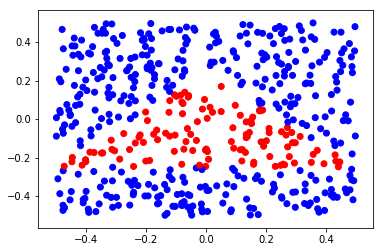

In [8]:
def build_triangle(n=10):  
    X = np.random.rand(n, 2)-0.5
    # assume l1, l2, and l3 are the parameters of a line
    # e.g. [theta1, theta2, b]: theta1 x1 + theta2 x2 + b <= 0
    lines = [[1,1,-0.25], [-1, 1, -0.25], [0, -1, -0.25]]
    y = np.ones(n)
    for l in lines:
        t1, t2, b = l
        y = np.logical_and((X.dot([t1, t2]) + b) <= 0, y)
    return X, y.astype(int) * 2 - 1

def plotData(X, y):
    plt.scatter(X[:,0], X[:,1], c=list(map(lambda x: 'b' if x==-1 else 'r', y)))
    plt.show()

n = 500
X, Y = build_triangle(n)
plotData(X, Y)

0.12% (0m 0s) 0.0013


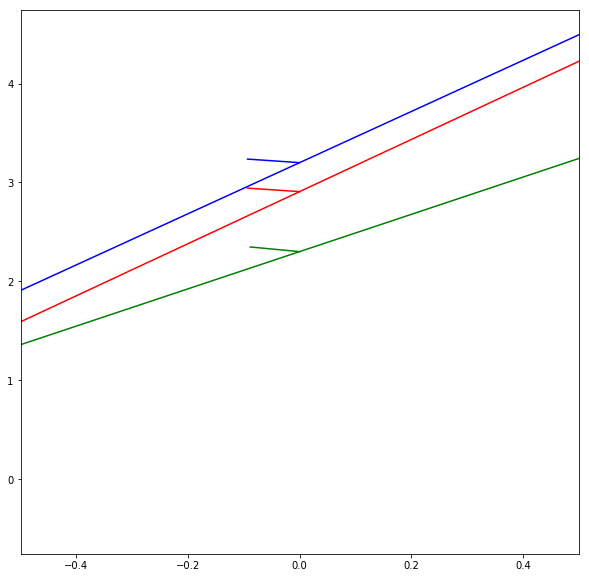

probability of choosing r is 0.142
probability of choosing g is 0.858
probability of choosing b is 0.0
p(y=-1|z="r") is 0.7660818696022034
p(y=-1|z="g") is 0.7861271500587463
p(y=-1|z="b") is 0.75


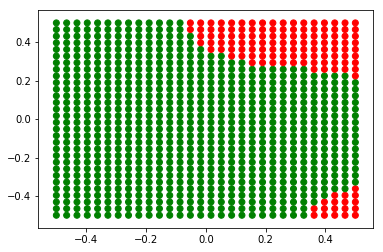

12.62% (0m 6s) 0.0010


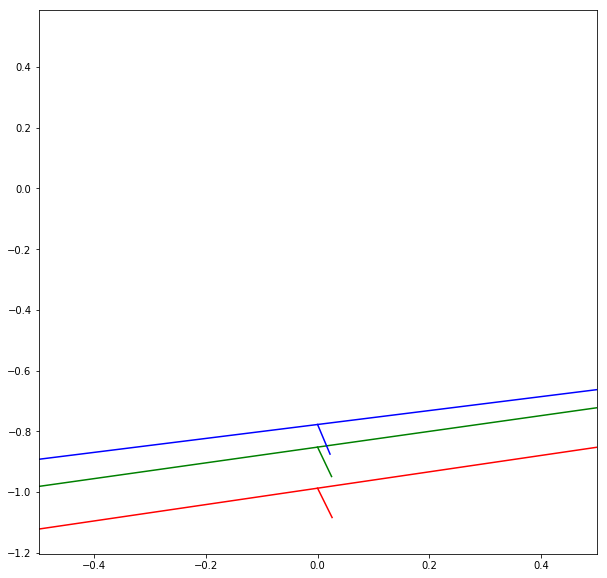

probability of choosing r is 0.518
probability of choosing g is 0.132
probability of choosing b is 0.35
p(y=-1|z="r") is 0.7727272510528564
p(y=-1|z="g") is 0.7540983557701111
p(y=-1|z="b") is 0.7791411280632019


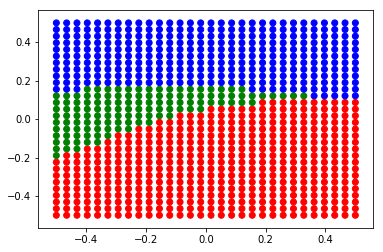

25.12% (0m 12s) 0.0007


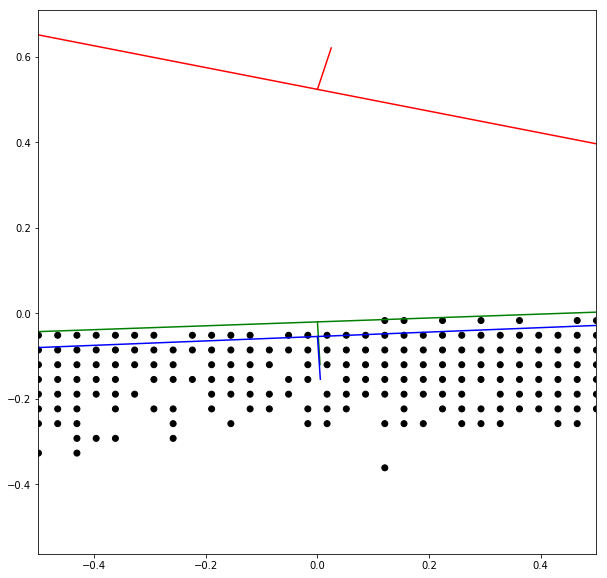

probability of choosing r is 0.27
probability of choosing g is 0.358
probability of choosing b is 0.372
p(y=-1|z="r") is 0.932330846786499
p(y=-1|z="g") is 0.5813953280448914
p(y=-1|z="b") is 0.8881579041481018


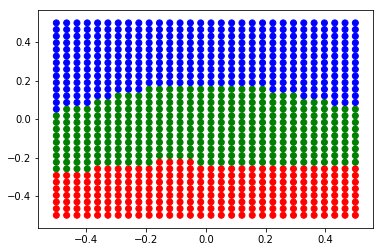

37.62% (0m 19s) 0.0004


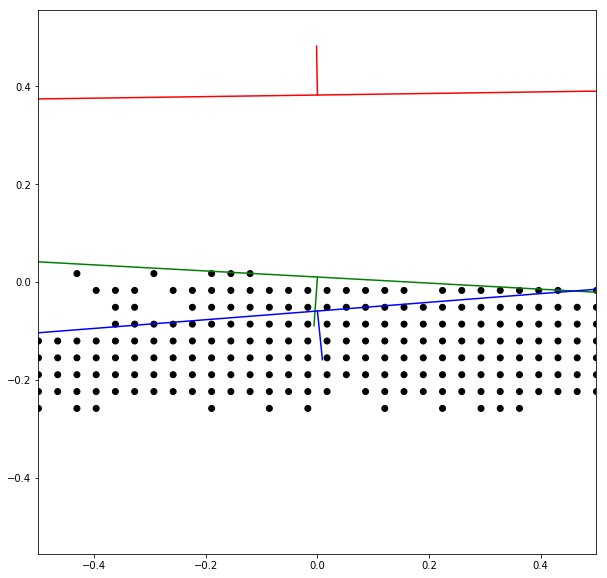

probability of choosing r is 0.264
probability of choosing g is 0.438
probability of choosing b is 0.298
p(y=-1|z="r") is 0.9844961166381836
p(y=-1|z="g") is 0.5550661087036133
p(y=-1|z="b") is 0.9097222089767456


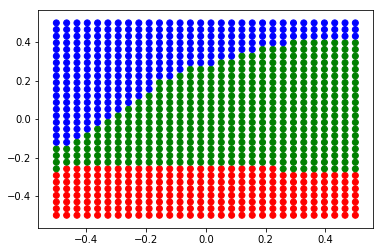

50.12% (0m 25s) 0.0002


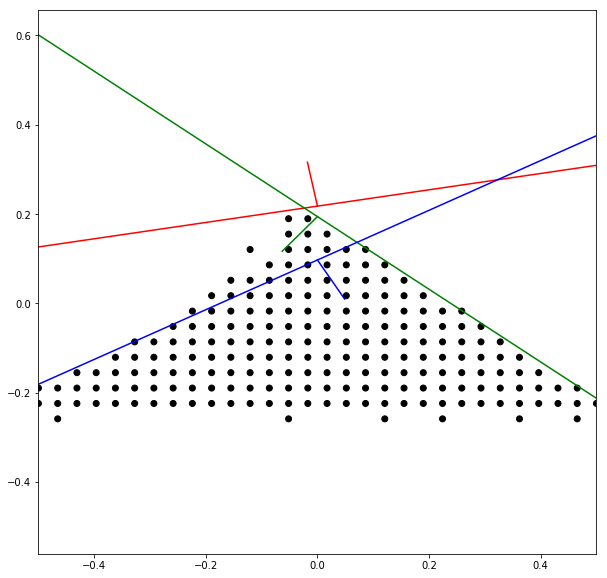

probability of choosing r is 0.268
probability of choosing g is 0.42
probability of choosing b is 0.312
p(y=-1|z="r") is 0.9924242496490479
p(y=-1|z="g") is 0.5167464017868042
p(y=-1|z="b") is 0.9119496941566467


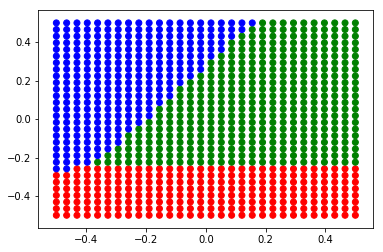

62.62% (0m 32s) 0.0001


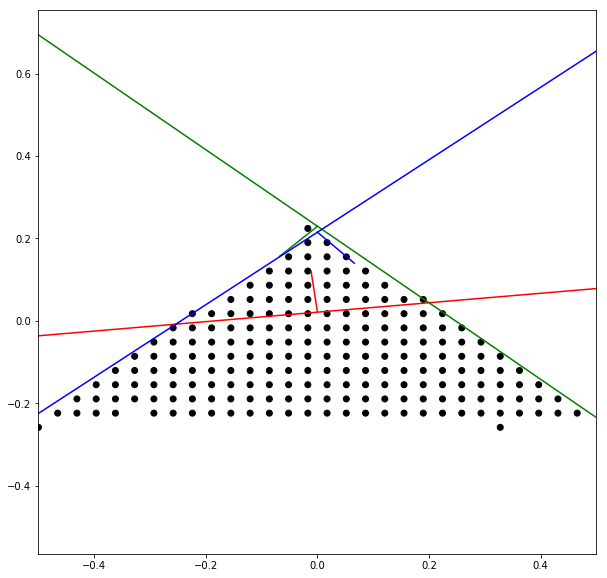

probability of choosing r is 0.268
probability of choosing g is 0.416
probability of choosing b is 0.316
p(y=-1|z="r") is 0.9924812316894531
p(y=-1|z="g") is 0.5362318754196167
p(y=-1|z="b") is 0.8812500238418579


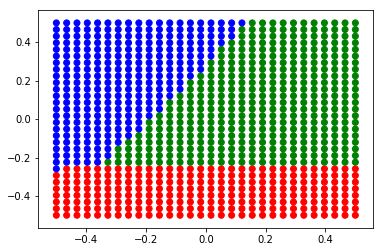

75.12% (0m 38s) 0.0001


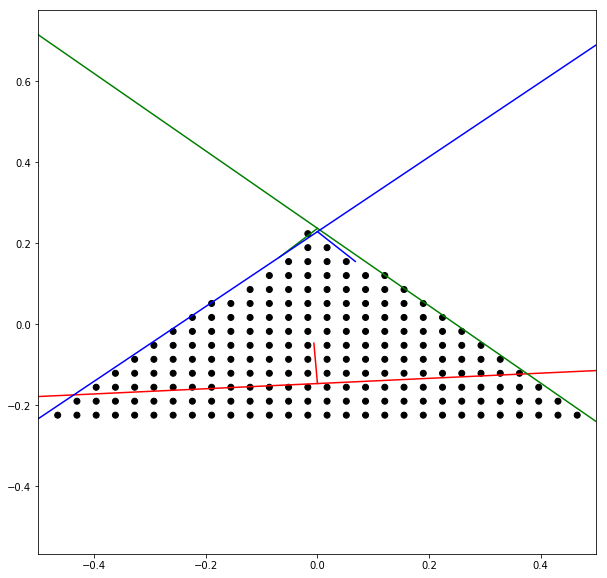

probability of choosing r is 0.268
probability of choosing g is 0.416
probability of choosing b is 0.316
p(y=-1|z="r") is 0.9924812316894531
p(y=-1|z="g") is 0.5311004519462585
p(y=-1|z="b") is 0.892405092716217


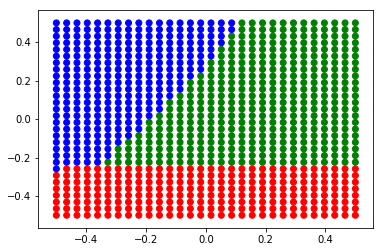

/data/jiaxuan/credible_learning/lib/train.py:181: RuntimeWarning: invalid value encountered in less
  z_index = [np.random.choice(self.switch_size, p=prob[i]) for i in range(n)]


87.62% (0m 45s) nan


/data/jiaxuan/credible_learning/lib/utility.py:181: RuntimeWarning: invalid value encountered in greater
  Z = (Z > 0).astype(np.int)


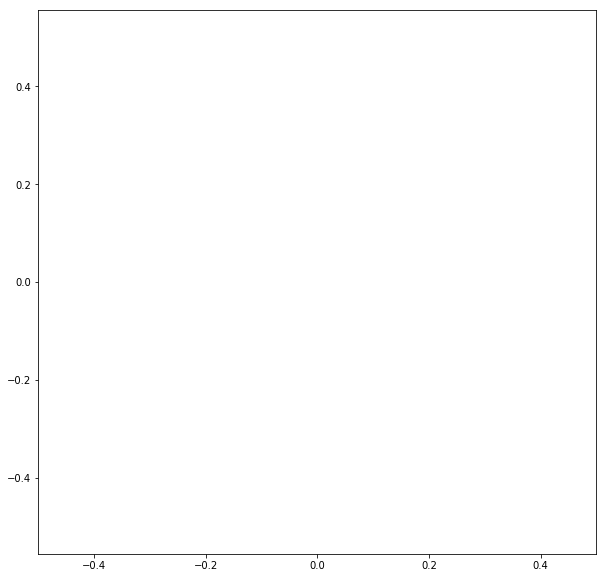

probability of choosing r is 1.0
probability of choosing g is 0.0
probability of choosing b is 0.0
p(y=-1|z="r") is 0.7680000066757202
p(y=-1|z="g") is 0.0
p(y=-1|z="b") is 0.0


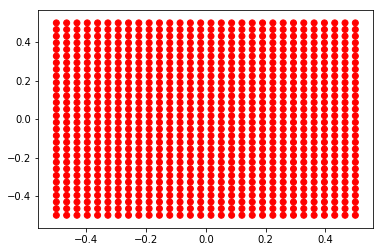

ValueError: range parameter must be finite.

In [9]:
input_size = 2 # 2d input
switch_size = 3 # can only output 3 lines

x = Variable(torch.from_numpy(X)).float()
y = Variable(torch.from_numpy(Y)).float()

switch = Switch(input_size, switch_size)
weight = Weight(switch_size, input_size+1) # +1 for b in linear model

max_grad = 0.1
log_name = 'with_gradient_clipping'
t =  InterpretableTrainer(switch, weight, apply_linear, alpha=-0.5, beta=0.6, 
                          log_name=log_name, max_grad=max_grad)

# fit a model here:
train_data = TensorDataset(x.data, y.data)
data = DataLoader(train_data, batch_size=n, shuffle=True)
t.fit(data, n_epochs=800, print_every=100)


[[0.22040830552577972, -0.33467501401901245, -6.0782470703125], [-13.001266479492188, -18.066299438476562, -0.3665836453437805], [-0.5686854124069214, 0.7232837080955505, 4.45086145401001]]


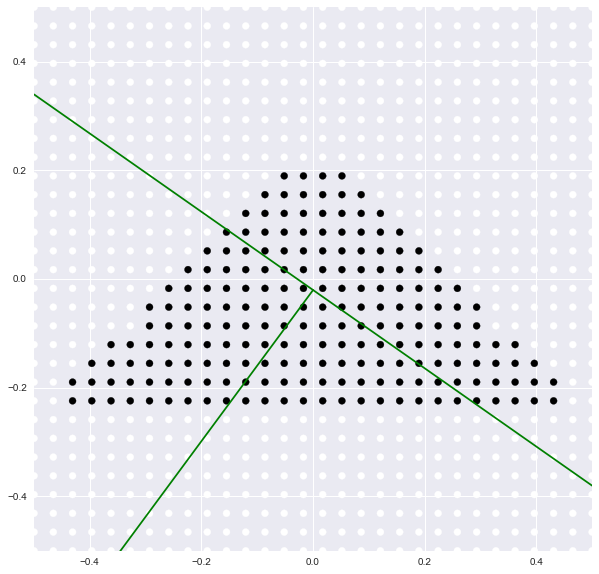

In [19]:
plt.figure(figsize=(10,10))

plotDecisionSurface(t.forward, -0.5, 0.5, -0.5, 0.5, multioutput=False)
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

colors = ['r','g','b','k','purple']
#lines = [[1,1,-0.25], [-1, 1, -0.25], [0, -1, -0.25]]
lines = weight.explain()[-3:]
print(lines)
for i, (t1, t2, b) in enumerate(lines):
    # t1 x + t2 y + b = 0
    # y = - (t1 x + b) / t2
    def l(x):
        return - (t1 * x + b) / t2

#     a = np.array([-0.5, l(-0.5)])
#     b = np.array([0.5, l(0.5)])
#     print((b-a).dot(np.array([t1,t2])))

    plt.plot([-0.5, 0.5], [l(-0.5), l(0.5)], c=colors[i])
    #print(t1, t2)
    plt.plot([0, 0+t1], [l(0), l(0)+t2], c=colors[i])
    #plt.plot([0, t1], [0, t2], c=colors[i])
plt.show()

## egg world

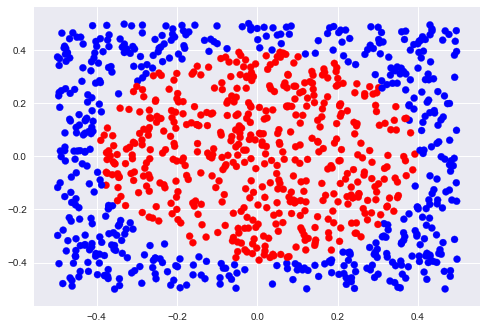

In [98]:
def build_circle(n=10):  
    X = np.random.rand(n, 2)-0.5
    y = (X[:,0]**2 + X[:, 1]**2 <= 0.16)
    return X, y.astype(int) * 2 - 1

def plotData(X, y):
    plt.scatter(X[:,0], X[:,1], c=list(map(lambda x: 'b' if x==-1 else 'r', y)))
    plt.show()

n = 1000
X, Y = build_circle(n)
plotData(X, Y)

0.12% (0m 0s) 0.0007


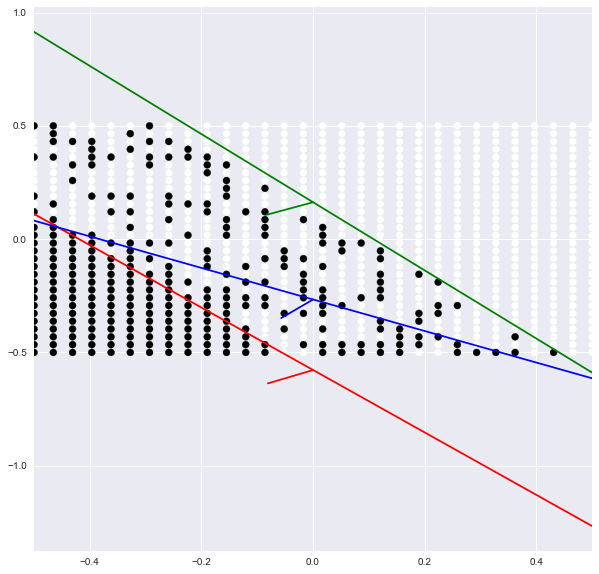

probability of choosing r is 0.84
probability of choosing g is 0.0
probability of choosing b is 0.16
p(y=-1|z="r") is 0.5198776721954346
p(y=-1|z="g") is 0.4795321524143219
p(y=-1|z="b") is 0.5256797671318054


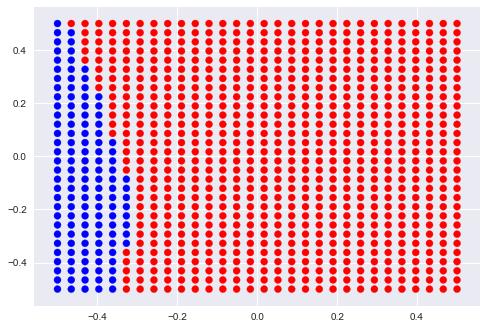

12.62% (0m 14s) 0.0004


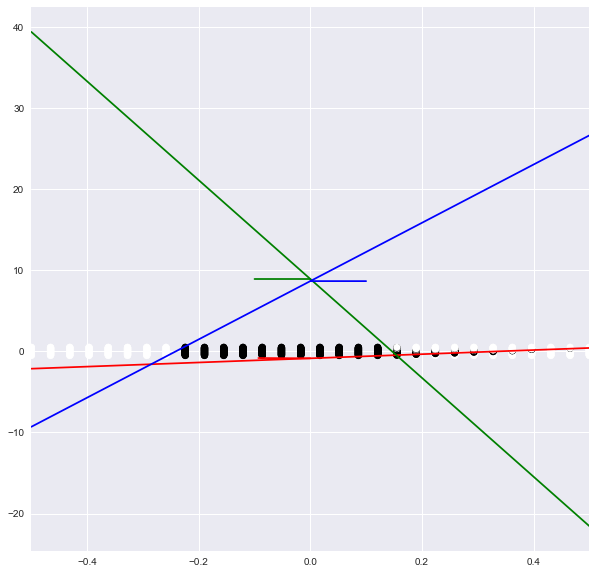

probability of choosing r is 0.255
probability of choosing g is 0.108
probability of choosing b is 0.637
p(y=-1|z="r") is 0.548872172832489
p(y=-1|z="g") is 0.8333333134651184
p(y=-1|z="b") is 0.43450480699539185


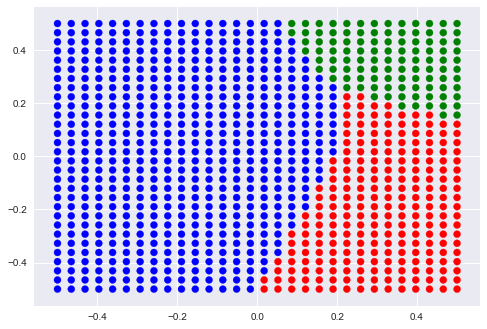

25.12% (0m 27s) 0.0003


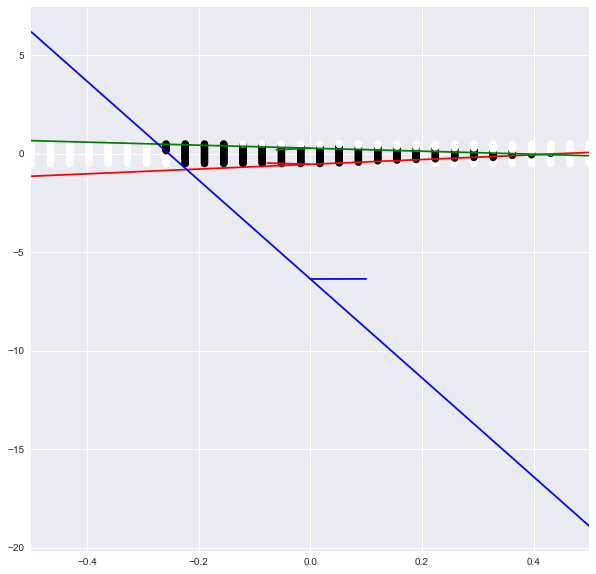

probability of choosing r is 0.171
probability of choosing g is 0.122
probability of choosing b is 0.707
p(y=-1|z="r") is 0.8047337532043457
p(y=-1|z="g") is 0.95652174949646
p(y=-1|z="b") is 0.3659217953681946


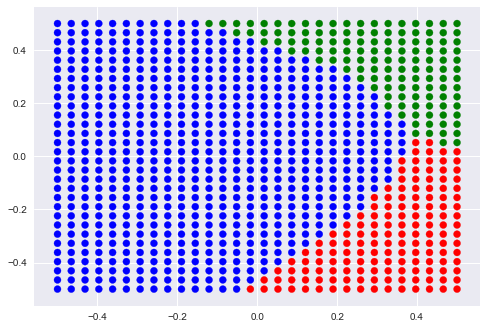

37.62% (0m 41s) 0.0002


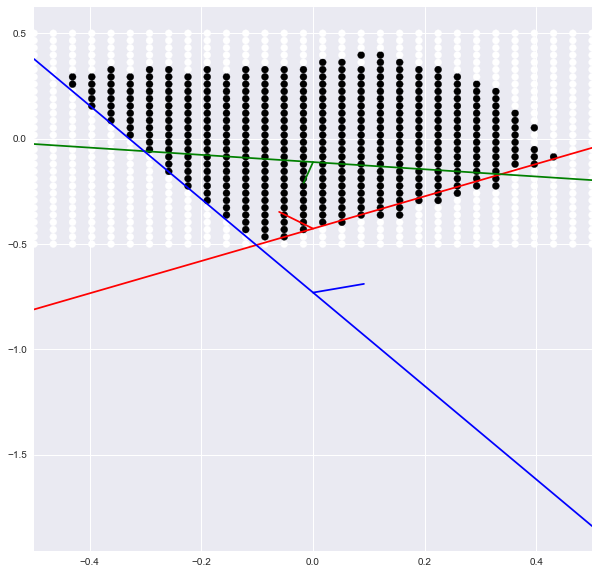

probability of choosing r is 0.127
probability of choosing g is 0.223
probability of choosing b is 0.65
p(y=-1|z="r") is 0.9242424368858337
p(y=-1|z="g") is 0.9409090876579285
p(y=-1|z="b") is 0.27623456716537476


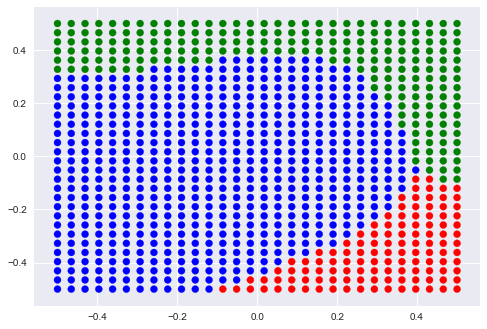

50.12% (0m 54s) 0.0002


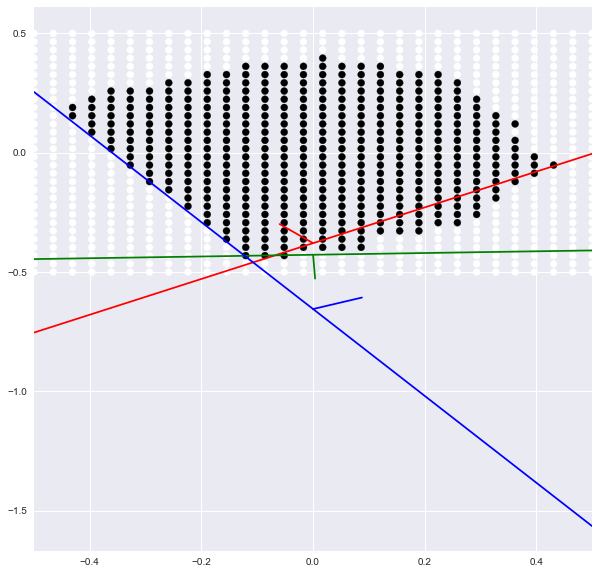

probability of choosing r is 0.127
probability of choosing g is 0.228
probability of choosing b is 0.645
p(y=-1|z="r") is 0.9765625
p(y=-1|z="g") is 0.9694322943687439
p(y=-1|z="b") is 0.2503888010978699


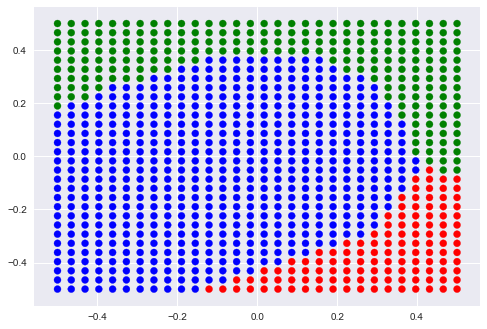

62.62% (1m 7s) 0.0001


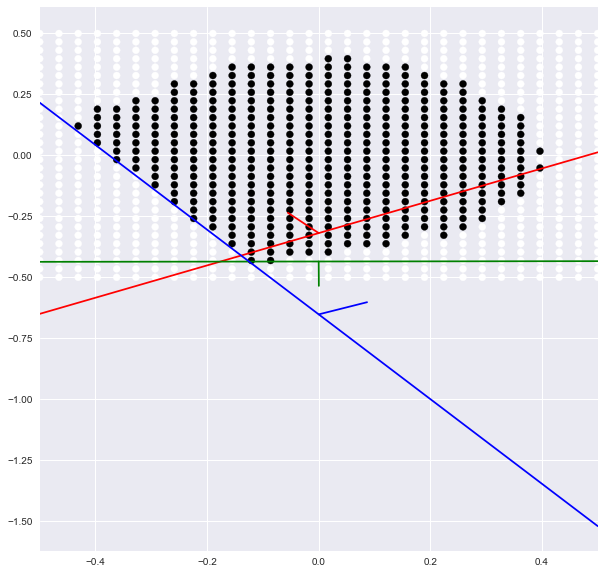

probability of choosing r is 0.13
probability of choosing g is 0.238
probability of choosing b is 0.632
p(y=-1|z="r") is 0.970588207244873
p(y=-1|z="g") is 0.9783549904823303
p(y=-1|z="b") is 0.2369668185710907


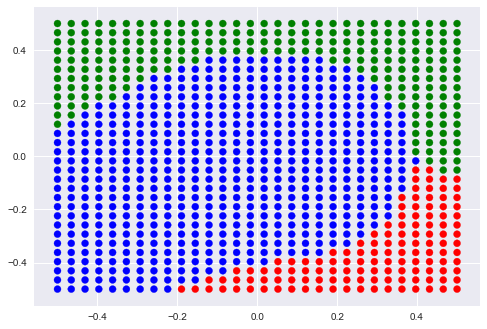

75.12% (1m 20s) 0.0001


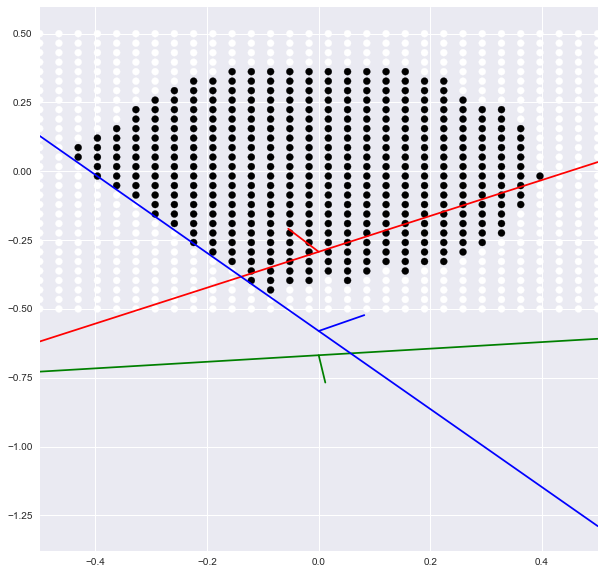

probability of choosing r is 0.13
probability of choosing g is 0.247
probability of choosing b is 0.623
p(y=-1|z="r") is 0.9924242496490479
p(y=-1|z="g") is 0.9755101799964905
p(y=-1|z="b") is 0.22150883078575134


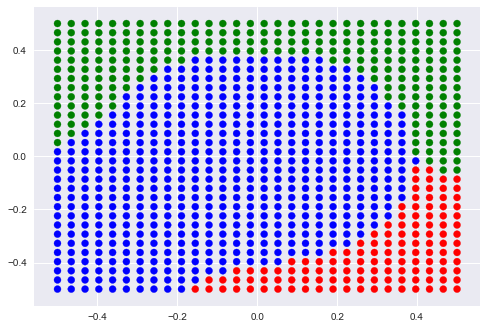

87.62% (1m 35s) 0.0001


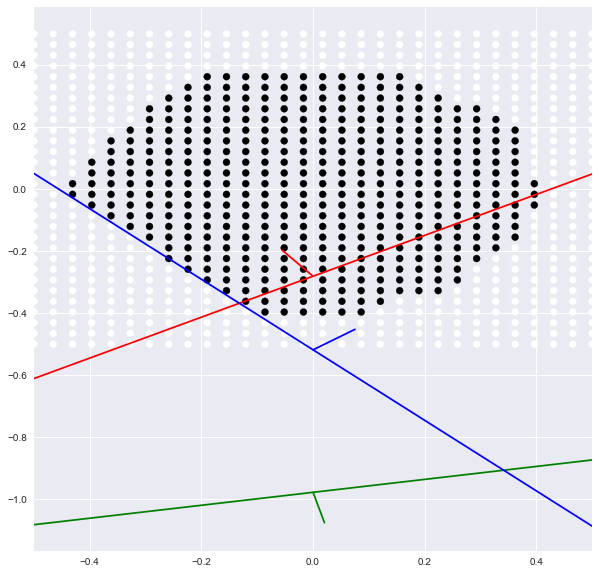

probability of choosing r is 0.131
probability of choosing g is 0.26
probability of choosing b is 0.609
p(y=-1|z="r") is 0.9923076629638672
p(y=-1|z="g") is 0.9731800556182861
p(y=-1|z="b") is 0.20525451004505157


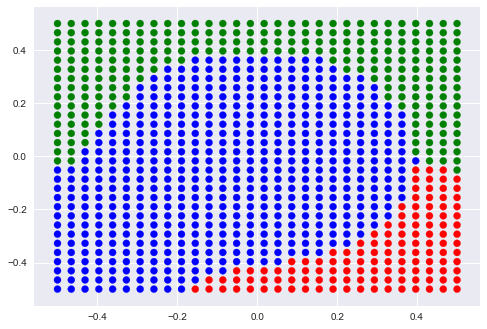

[0.0006949847340583801,
 0.0004435677230358124,
 0.0003390769064426422,
 0.00022939470410346984,
 0.00017481978237628937,
 0.00010396948456764222,
 7.823505997657775e-05,
 6.418254971504211e-05]

In [99]:
input_size = 2 # 2d input
switch_size = 3 # can only output 3 lines

x = Variable(torch.from_numpy(X)).float()
y = Variable(torch.from_numpy(Y)).float()

switch = Switch(input_size, switch_size)
weight = Weight(switch_size, input_size+1) # +1 for b in linear model

t =  InterpretableTrainer(switch, weight, apply_linear, alpha=0, beta=0.6)

# fit a model here:
train_data = TensorDataset(x.data, y.data)
data = DataLoader(train_data, batch_size=1000, shuffle=True)
t.fit(data, n_epochs=800, print_every=100)

[[-15.706901550292969, 24.064462661743164, 6.361767768859863], [0.7517687082290649, -2.9694643020629883, -3.2380988597869873], [25.67020606994629, 22.626176834106445, 11.720215797424316]]


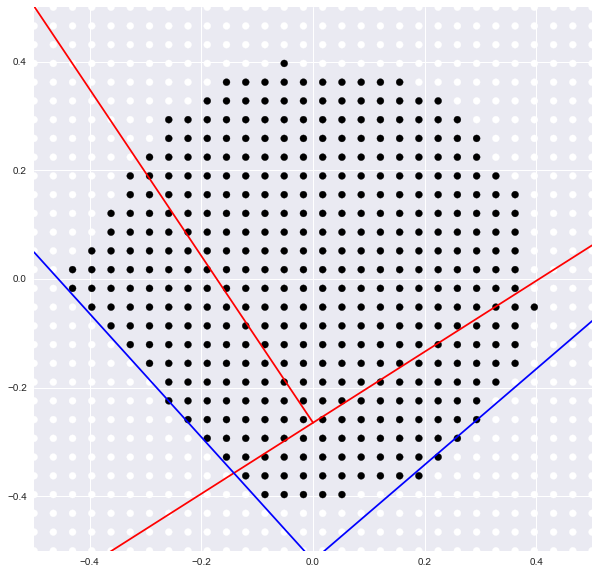

In [103]:
plt.figure(figsize=(10,10))

plotDecisionSurface(t.forward, -0.5, 0.5, -0.5, 0.5, multioutput=False)
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

colors = ['r','g','b','k','purple']
#lines = [[1,1,-0.25], [-1, 1, -0.25], [0, -1, -0.25]]
lines = weight.explain()[-3:]
print(lines)
for i, (t1, t2, b) in enumerate(lines):
    # t1 x + t2 y + b = 0
    # y = - (t1 x + b) / t2
    def l(x):
        return - (t1 * x + b) / t2

#     a = np.array([-0.5, l(-0.5)])
#     b = np.array([0.5, l(0.5)])
#     print((b-a).dot(np.array([t1,t2])))

    plt.plot([-0.5, 0.5], [l(-0.5), l(0.5)], c=colors[i])
    #print(t1, t2)
    plt.plot([0, 0+t1], [l(0), l(0)+t2], c=colors[i])
    #plt.plot([0, t1], [0, t2], c=colors[i])
plt.show()